In [1]:
from sympy import *
init_printing()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


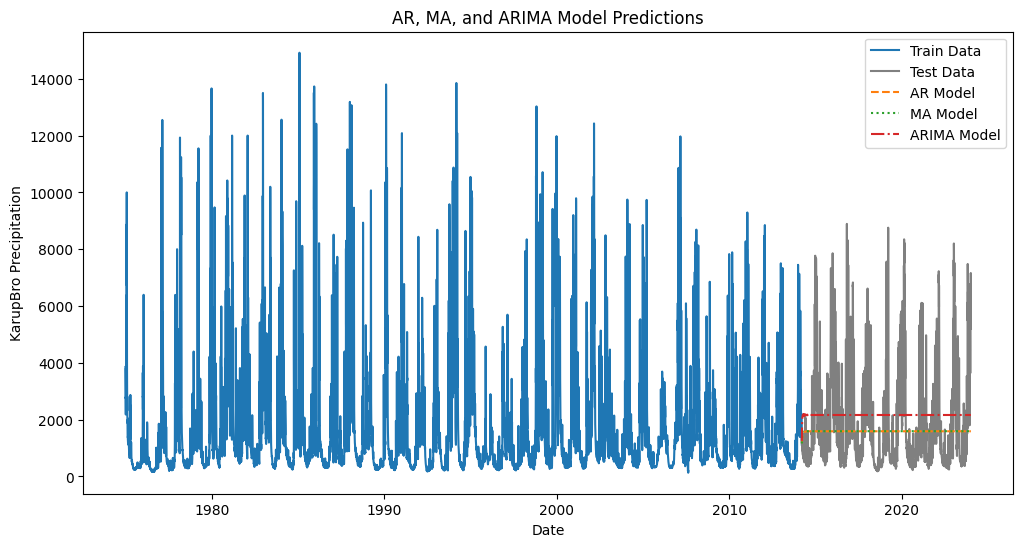

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

# Load dataset
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_K\u00f8rup_Parken_VNF_d\u00f8gn_1975-2023.csv"
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names
korup_parken_df.columns = korup_parken_df.columns.str.strip()
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Drop the BygholmPark column
korup_parken_df = korup_parken_df.drop(columns=["BygholmPark"])

# Sort by timestamp
korup_parken_df = korup_parken_df.sort_values("timestamp").reset_index(drop=True)

# Ensure no missing values
korup_parken_df = korup_parken_df.dropna()

# Split train and test
train = korup_parken_df.iloc[:-int(len(korup_parken_df) * 0.2)]
test = korup_parken_df.iloc[-int(len(korup_parken_df) * 0.2):]

# --- Autoregression (AR) Model ---
model_ar = AutoReg(train["KarupBro"], lags=15).fit()
pred_ar = model_ar.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# --- Moving Average (MA) Model ---
model_ma = ARIMA(train["KarupBro"], order=(0, 0, 15)).fit()
pred_ma = model_ma.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# --- ARIMA Model (AR + I + MA) ---
model_arima = ARIMA(train["KarupBro"], order=(15, 1, 15)).fit()
pred_arima = model_arima.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, typ='levels')

# --- Plot results ---
plt.figure(figsize=(12, 6))
plt.plot(train["timestamp"], train["KarupBro"], label="Train Data")
plt.plot(test["timestamp"], test["KarupBro"], label="Test Data", color='gray')
plt.plot(test["timestamp"], pred_ar, label="AR Model", linestyle='dashed')
plt.plot(test["timestamp"], pred_ma, label="MA Model", linestyle='dotted')
plt.plot(test["timestamp"], pred_arima, label="ARIMA Model", linestyle='dashdot')
plt.xlabel("Date")
plt.ylabel("KarupBro Precipitation")
plt.title("AR, MA, and ARIMA Model Predictions")
plt.legend()
plt.show()